<a href="https://colab.research.google.com/github/1155194577/music_embedding_lab/blob/main/music2vec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.3/474.3 kB 25.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 13.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 15.0 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pyarrow<15.0.0a0,>=14.0.1, but you have pyarrow 17.0.0 which is incompatible.
ibis-framework 8.0.0 requires pyarrow<16,>=2, but you have pyarrow 17.0.0 which is incompatible.


In [11]:
from transformers import Wav2Vec2Processor, Data2VecAudioModel
import torch
from torch import nn
from datasets import load_dataset

# load demo audio and set processor
dataset = load_dataset("hf-internal-testing/librispeech_asr_demo", "clean", split="validation")
dataset = dataset.sort("id")
sampling_rate = dataset.features["audio"].sampling_rate
processor = Wav2Vec2Processor.from_pretrained("facebook/data2vec-audio-base-960h")

# loading our model weights
model = Data2VecAudioModel.from_pretrained("m-a-p/music2vec-v1")


# audio file is decoded on the fly
inputs = processor(dataset[0]["audio"]["array"], sampling_rate=sampling_rate, return_tensors="pt")
with torch.no_grad():
    outputs = model(**inputs, output_hidden_states=True)

# take a look at the output shape, there are 13 layers of representation
# each layer performs differently in different downstream tasks, you should choose empirically
all_layer_hidden_states = torch.stack(outputs.hidden_states).squeeze()
print(all_layer_hidden_states.shape) # [13 layer, 292 timestep, 768 feature_dim]

# for utterance level classification tasks, you can simply reduce the representation in time
time_reduced_hidden_states = all_layer_hidden_states.mean(-2)
print(time_reduced_hidden_states.shape) # [13, 768]

# you can even use a learnable weighted average representation
aggregator = nn.Conv1d(in_channels=13, out_channels=1, kernel_size=1)
weighted_avg_hidden_states = aggregator(time_reduced_hidden_states).squeeze()
print(weighted_avg_hidden_states.shape) # [768]


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


torch.Size([13, 292, 768])
torch.Size([13, 768])
torch.Size([768])


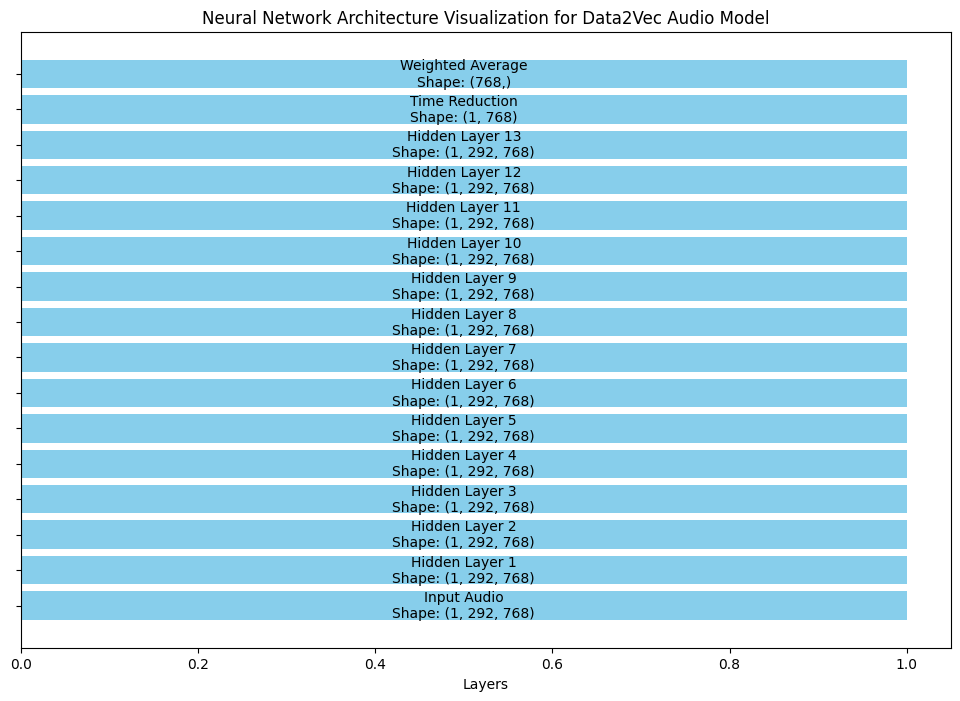

In [13]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_nn():
    # Create a figure
    fig, ax = plt.subplots(figsize=(12, 8))

    # Define the layers and their properties
    layers = [
        ("Input Audio", (1, 292, 768)),  # Shape: [batch_size, timesteps, feature_dim]
        ("Hidden Layer 1", (1, 292, 768)),
        ("Hidden Layer 2", (1, 292, 768)),
        ("Hidden Layer 3", (1, 292, 768)),
        ("Hidden Layer 4", (1, 292, 768)),
        ("Hidden Layer 5", (1, 292, 768)),
        ("Hidden Layer 6", (1, 292, 768)),
        ("Hidden Layer 7", (1, 292, 768)),
        ("Hidden Layer 8", (1, 292, 768)),
        ("Hidden Layer 9", (1, 292, 768)),
        ("Hidden Layer 10", (1, 292, 768)),
        ("Hidden Layer 11", (1, 292, 768)),
        ("Hidden Layer 12", (1, 292, 768)),
        ("Hidden Layer 13", (1, 292, 768)),
        ("Time Reduction", (1, 768)),  # Average across timesteps
        ("Weighted Average", (768,))     # Final vector representation
    ]

    # Define positions for layers
    y_positions = np.arange(len(layers))

    # Create bars for each layer
    for i, (layer_name, shape) in enumerate(layers):
        ax.barh(i, 1, left=0, color='skyblue')
        ax.text(0.5, i, f"{layer_name}\nShape: {shape}", ha='center', va='center', fontsize=10)

    # Set y-ticks
    ax.set_yticks(y_positions)
    ax.set_yticklabels([])
    ax.set_xlabel('Layers')
    ax.set_title('Neural Network Architecture Visualization for Data2Vec Audio Model')

    # Remove gridlines
    ax.grid(False)

    # Show the plot
    plt.show()

# Call the function to visualize the neural network
visualize_nn()